In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 3
macro_configs = config_generator(g_tilde=[20, 10, 15, 20],
                                 q_tilde=[200000, 400000],
                                 shape=['exp', 'step'],
                                 somp=[False, True])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [15]:
N = 2000
#Random modes
U = np.random.normal(0, 1/np.sqrt(N), (N, N))
VT = np.random.normal(0, 1/np.sqrt(N), (N, N))

#Get approximately desired g and q
g_tilde = params['g_tilde']
q_tilde = params['q_tilde']

#Compute S for the exponential
C = np.sqrt(2*q_tilde)/g_tilde
a = q_tilde/g_tilde**4
S = C*np.exp(-a*np.arange(N)/N)

#Compute actual g and q for exponential
g = np.sqrt((S**2).mean())
q = (S**4).mean()

#Compute S for the step function
alpha = 1 - g**4/q
D = np.sqrt(q)/g

#switch to step function if that's what we're doing
if params['shape'] == 'step':
    S = np.zeros(N)
    S[int(alpha*N):] = D

W = U.dot(np.diag(S)).dot(VT)
if params['somp'] or True:
    W = g*np.random.normal(0, 1/np.sqrt(N), (N, N))
    U, S, VT = np.linalg.svd(W)
    q = (S**4).mean()

In [16]:
phi_numpy = lambda x: erf((np.sqrt(np.pi)/2)*x)
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime = lambda x: np.exp(-(np.pi/4)*x**2)
def run_sim(T_sim, T_eval, dt, W, N_batch=1):
    device = W.device
    N = W.shape[0]
    eval_iter = int(T_eval / dt)
    Nt = int(T_sim / dt)
    N_save = int(T_sim / T_eval)
    #define stuff
    x_save = torch.zeros(N_save, N_batch, N, device=device)
    x = torch.randn(N_batch, N, device=device) * torch.std(W).item() * np.sqrt(N)
    x_save[0] = x
    r_lpf = x.clone()
    r_lpf_save = torch.zeros_like(x_save)
    r_lpf_save[0] = r_lpf
    #run
    for i in range(1, Nt):
        r = phi_torch(x)
        r_lpf += dt*(-r_lpf + r)
        x += dt*(-x + torch.mm(r, W.T)) + torch.randn(size=r.shape, device=device)*np.sqrt(dt)
        if i % eval_iter == 0:
            x_save[i//eval_iter] = x
            r_lpf_save[i//eval_iter] = r_lpf
    return x_save, r_lpf_save

In [17]:
#Estimate single unit properties
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
dt = 0.01
dt_save = 0.01
x_save, r_lpf_save = run_sim(2000, dt_save, dt, W_)
T_initial = 100
x = x_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
psi_emp = phi_prime(x).mean(1)
phi_lpf = r_lpf_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
r = phi_numpy(x)

In [ ]:
#Compute fourier things
C_phi_emp = np.fft.irfft((np.abs(np.fft.rfft(r, axis=0, norm='ortho'))**2).mean(1))

In [74]:
T_window = 100
n_window = int(T_window/dt_save)
C_phi_emp_omega = np.fft.rfft(C_phi_emp[:n_window], norm='ortho')
alpha_emp = phi_prime(x).mean()
omega = np.fft.rfftfreq(n_window, d=0.01)
S_phi = alpha_emp/(1 + (0 + 1j)*omega)
S_phi_S_phi = np.multiply.outer(S_phi, S_phi)
C_phi_C_phi = np.multiply.outer(C_phi_emp_omega, C_phi_emp_omega)

In [43]:
#Estimate my weird Psi expression
term_1 = (g**4 * np.abs(S_phi_S_phi)**2 * (g**4 + q) * C_phi_C_phi)/(1 - (2*np.pi)**2 * g**8 *np.abs(S_phi_S_phi)**2)
term_2 = (g**2 * S_phi_S_phi * C_phi_C_phi)/(2*np.pi * (1 - 2*np.pi*g**2*S_phi_S_phi)*(1 - (2*np.pi)**2 * g**8 * (np.abs(S_phi_S_phi))**2))
Psi = (2*np.pi)**2 * (term_1 + term_2)
Psi_tau = np.fft.irfft(np.fft.irfft(Psi, axis=0), axis=1)

In [75]:
#David's Psi expression
Psi_prx = (1/(np.abs(1 - 2*np.pi*g**2*S_phi_S_phi)**2) - 1)*C_phi_C_phi
Psi_prx_tau = np.fft.irfft(np.fft.irfft(Psi_prx, axis=0), axis=1)

In [ ]:
#David's Psi expression 2
thing = 1+(0+1j)*omega
Chi = np.multiply.outer(thing, thing)
nu = alpha_emp**2 * g**2
Psi_prx_2 = (np.abs(Chi/(Chi - nu))**2 - 1) * C_phi_C_phi
Psi_prx_tau_2 = np.fft.irfft(np.fft.irfft(Psi_prx_2, axis=0), axis=1)

In [ ]:
print(Psi_prx_tau[0,0]*N)
print(Psi_prx_tau_2[0,0]*N)

In [ ]:
#Estimate covariance unit
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
dt = 0.05
dt_save = 1
x_save, r_lpf_save = run_sim(30000, dt_save, dt, W_)
T_initial = 100
x = x_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
psi_emp = phi_prime(x).mean(1)
phi_lpf = r_lpf_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
r = phi_numpy(x)

In [15]:
X = r
X = X - X.mean(0)

psi_00_estimates = []
avg_X_var_squared = np.square((X * X).sum() / (X.shape[0] - 1))
avg_X_squared_var = np.square((X * X).sum(0) / (X.shape[0] - 1)).sum()
for i in range(20):
    shuffle_idx = random_derangement(X.shape[1])
    psi_00_estimates.append(np.square((X * X[:, shuffle_idx]).sum(0) / (X.shape[0] - 1)).sum())
psi_00 = np.mean(psi_00_estimates)

In [ ]:
processed_data = np.array([Psi_tau[0,0], Psi_prx_tau[0,0], psi_00])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [21]:
###Truncate file above
file_name = 'psi_theory_match'
job_name = 'psi00_match'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook psi_theory_match.ipynb to script
[NbConvertApp] Writing 10546 bytes to psi_theory_match.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ae59f6c5c90> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ae59f6c5c90> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [22]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=1, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/psi00_match/result_*’: No such file or directory
sending incremental file list

sent 1,427 bytes  received 28 bytes  2,910.00 bytes/sec
total size is 202,983  speedup is 139.51
sbatch  --exclude=ax[01-13],ax[17-19] --array=1-72 /home/om2382/low-rank-dims/job_scripts/psi00_match.s


In [ ]:
job_id_1 = submit_job(job_script_path, n_jobs)

In [25]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           2945045    lkumar  jupyter   om2382  R      46:34      1 ax16


In [2]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'psi00_match'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [ ]:
!ls -t ../job_scripts/

In [27]:
configs_array

{'g_tilde': [10, 15, 20],
 'q_tilde': [200000, 400000],
 'shape': ['exp', 'step'],
 'somp': [False, True],
 'i_seed': [0, 1, 2]}

In [28]:
results_array.shape

(3, 2, 2, 2, 3, 3)

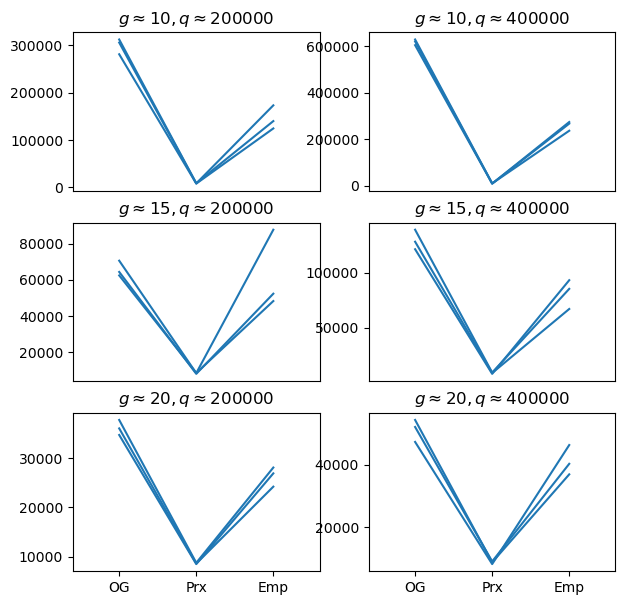

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(7,7))
for i in range(3):
    for j in range(2):
        for k in range(3):
            ax[i,j].plot([0.25, 0.5, 0.75], results_array[i,j,0,0,k,:]*np.array([1,1,2000]), color='C0')
            #ax[i,j].set_ylim([0, 0.08])
            if i==2:
                ax[i,j].set_xticks([0.25, 0.5, 0.75], ['OG', 'Prx', 'Emp'])
            else:
                ax[i,j].set_xticks([])
            ax[i,j].set_xlim([0.1, 0.9])
            ax[i,j].set_title(r'$g \approx {}, q \approx {}$'.format(configs_array['g_tilde'][i],
                                                                    configs_array['q_tilde'][j]))

IndexError: index 2 is out of bounds for axis 3 with size 2

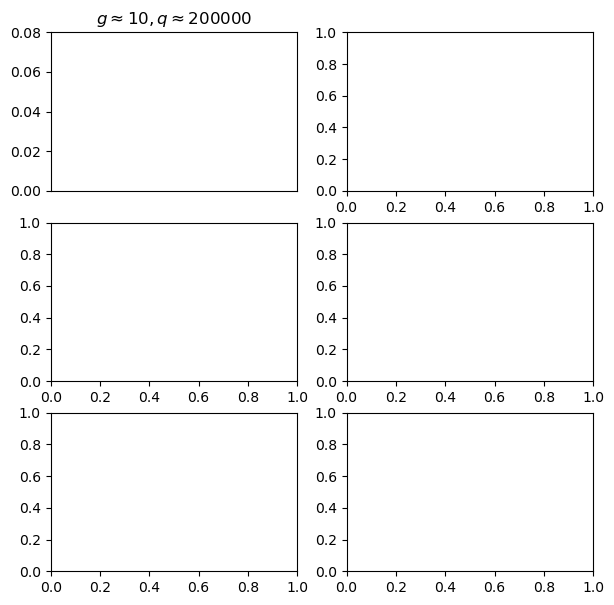

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(7,7))
for i in range(3):
    for j in range(2):
        for k in range(5):
            ax[i,j].plot([0.25, 0.75], results_array[i,j,:,k,1], color='C0')
            ax[i,j].set_ylim([0, 0.08])
            if i==2:
                ax[i,j].set_xticks([0.25, 0.75], ['Exp', 'Step'])
            else:
                ax[i,j].set_xticks([])
            ax[i,j].set_xlim([0.1, 0.9])
            ax[i,j].set_title(r'$g \approx {}, q \approx {}$'.format(configs_array['g_tilde'][i],
                                                                    configs_array['q_tilde'][j]))

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(20,7))
for i in range(3):
    for j in range(2):
        for k in range(10):
            ax[i,j].plot(results_array[i,:,j,k,0], color='C0')
            ax[i,j].set_ylim([0, 0.13])

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(20,7))
for i in range(3):
    for j in range(2):
        ax[i,j].plot(results_array[i,:,j,1,0])
        ax[i,j].set_ylim([0, 0.2])

In [ ]:
configs_array

In [ ]:
time_emp = np.arange(0, 15, 0.05)
fig, ax = plt.subplots(3, 3, figsize=(20,20))
for i in range(3):
    for j in range(3):
        for k in range(2):
            ls = ['--', '-'][k]
            ax[i,j].plot(time_emp, results_array[i,j,k,0,0,:len(time_emp)], color='C0', linestyle=ls)
            ax[i,j].plot(time_emp, results_array[i,j,k,1,0,:len(time_emp)], color='C1')
            ax[i,j].set_ylim([-2, 15])
            ax[i,j].axhline(y=0, color='k', linestyle='--')
            ax[i,j].axis('off')

In [ ]:
configs_array

In [ ]:
time_emp = np.arange(0, 15, 0.05)
fig, ax = plt.subplots(6, 19, figsize=(20,7))
for i in range(6):
    for j in range(19):
        ax[i,j].plot(time_emp, results_array[i,j,0,0,:len(time_emp)])
        ax[i,j].plot(time_emp, results_array[i,j,1,0,:len(time_emp)])
        ax[i,j].set_ylim([-2, 7])
        ax[i,j].axhline(y=0, color='k', linestyle='--')
        ax[i,j].axis('off')

In [ ]:
fig, ax = plt.subplots(4, 9, figsize=(7,7))
for i in range(4):
    for j in range(9):
        ax[i,j].plot(results_array[i,j,0,0,:])
        ax[i,j].plot(results_array[i,j,1,0,:])
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].axis('off')
        ax[i,j].set_ylim([0.1, 3000])

In [ ]:
fig, ax = plt.subplots(6, 20, figsize=(21,7))
for i in range(6):
    for j in range(20):
        ax[i,j].plot(results_array[i,j,0,0,:])
        ax[i,j].plot(results_array[i,j,1,0,:])
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].axis('off')
        ax[i,j].set_ylim([0.1, 3000])

In [ ]:
fig, ax = plt.subplots(5, 9, figsize=(16,8))
for i in range(5):
    for j in range(9):
        ax[i,j].plot(results_array[j,i,0,0,:], color='C2')
        ax[i,j].plot(results_array[j,i,0,1,:], color='C0')
        ax[i,j].plot(results_array[j,i,0,2,:]/results_array[j,i,0,2,0], color='C1')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].axis('off')
        ax[i,j].set_ylim([0.00001, 3000])
fig.savefig('figs/spectra_usv_S_sing.pdf')

In [ ]:
fig, ax = plt.subplots(5, 9, figsize=(16,8))
time_emp = np.arange(0, 15, 0.05)

for i in range(5):
    for j in range(9):
        ax[i,j].plot(time_emp, results_array[j,i,0,:len(time_emp)], color='k')
        ax[i,j].plot(time_emp, Delta_emp[:len(time_emp)], color='C4')
        #ax[i,j].set_xscale('log')
        #ax[i,j].set_yscale('log')
        ax[i,j].axis('off')
        ax[i,j].set_ylim([-2, 7])
        ax[i,j].axhline(y=0, color='k', linestyle='--')
        #ax[i,j].set_ylim([0.00001, 3000])
fig.savefig('figs/autocov_usv_S_sing.pdf')

In [ ]:
results_array.shape

In [ ]:
plt.plot(results_array[-1, 1,0,0,:])
plt.xscale('log')
plt.yscale('log')